In [1]:
import os
import random
import torch
from torch import nn
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
import lovely_tensors as lt
lt.monkey_patch()

from csng.models.gan import GAN
from csng.utils.data import crop
from csng.data import get_dataloaders
from csng.models.readins import MEIReadIn
from csng.utils.mix import seed_all, update_config_paths, update_config_keys_to_value, plot_comparison, check_if_data_zscored
from csng.models.utils.gan import init_decoder as init_gan_decoder
from csng.models.utils.cnn import init_decoder as init_cnn_decoder
from csng.losses import SSIMLoss, MSELoss, Loss, get_metrics, VGGPerceptualLoss
from csng.models.readins import (
    MultiReadIn,
    ConvReadIn,
    FCReadIn,
    MEIReadIn,
)
from csng.models.utils.gan import train
from csng.utils.comparison import eval_decoder
from csng.losses import get_metrics

In [2]:
### setup config
config = {
    "device": os.environ["DEVICE"],
    "seed": 0,
    "data": {"mixing_strategy": "parallel_min"},
    "crop_wins": {"cat_v1": (20, 20), "mouse_v1": (22, 36), "brainreader_mouse": (36, 64)},
}

print(f"... Running on {config['device']} ...")
seed_all(config["seed"])

... Running on cuda:0 ...


# Data

## Load source dataset(s)

In [3]:
### set paths
DATA_PATH = os.environ["DATA_PATH"]
DATA_PATH_CAT_V1 = os.path.join(DATA_PATH, "cat_V1_spiking_model", "50K_single_trial_dataset")
DATA_PATH_MOUSE_V1 = os.path.join(DATA_PATH, "mouse_v1_sensorium22")
DATA_PATH_BRAINREADER = os.path.join(DATA_PATH, "brainreader")

print(f"{DATA_PATH=}")
print(f"{DATA_PATH_CAT_V1=}")
print(f"{DATA_PATH_MOUSE_V1=}")
print(f"{DATA_PATH_BRAINREADER=}")

DATA_PATH='/media/jan/ext_ssd/csng_data'
DATA_PATH_CAT_V1='/media/jan/ext_ssd/csng_data/cat_V1_spiking_model/50K_single_trial_dataset'
DATA_PATH_MOUSE_V1='/media/jan/ext_ssd/csng_data/mouse_v1_sensorium22'
DATA_PATH_BRAINREADER='/media/jan/ext_ssd/csng_data/brainreader'


In [4]:
### prep data config
# brainreader mouse data
# config["data"]["brainreader_mouse"] = {
#     "device": config["device"],
#     "mixing_strategy": config["data"]["mixing_strategy"],
#     "max_batches": None,
#     "data_dir": os.path.join(DATA_PATH_BRAINREADER, "data"),
#     "batch_size": 8,
#     # "sessions": list(range(1, 23)),
#     "sessions": [6],
#     "resize_stim_to": (36, 64),
#     "normalize_stim": True,
#     "normalize_resp": False,
#     "div_resp_by_std": True,
#     "clamp_neg_resp": False,
#     "additional_keys": None,
#     "avg_test_resp": True,
# }

### cat v1 data
config["data"]["cat_v1"] = {
    "dataset_config": {
        "train_path": os.path.join(DATA_PATH_CAT_V1, "datasets", "train"),
        "val_path": os.path.join(DATA_PATH_CAT_V1, "datasets", "val"),
        "test_path": os.path.join(DATA_PATH_CAT_V1, "datasets", "test"),
        "image_size": [50, 50],
        "crop": False,
        "batch_size": 16,
        "stim_keys": ("stim",),
        "resp_keys": ("exc_resp", "inh_resp"),
        "return_coords": True,
        "return_ori": False,
        "coords_ori_filepath": os.path.join(DATA_PATH_CAT_V1, "pos_and_ori.pkl"),
        "cached": False,
        "stim_normalize_mean": 46.143,
        "stim_normalize_std": 24.960,
        "resp_normalize_mean": None, # don't center responses
        "resp_normalize_std": torch.load(
            os.path.join(DATA_PATH_CAT_V1, "responses_std.pt")
        ),
        "clamp_neg_resp": False,
    },
}

# # mouse v1 data
# config["data"]["mouse_v1"] = {
#     "dataset_fn": "sensorium.datasets.static_loaders",
#     "dataset_config": {
#         "paths": [ # from https://gin.g-node.org/cajal/Sensorium2022/src/master
#             os.path.join(DATA_PATH_MOUSE_V1, "static21067-10-18-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip"), # M-1
#             os.path.join(DATA_PATH_MOUSE_V1, "static22846-10-16-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip"), # M-2
#             os.path.join(DATA_PATH_MOUSE_V1, "static23343-5-17-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip"), # M-3
#             os.path.join(DATA_PATH_MOUSE_V1, "static23656-14-22-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip"), # M-4
#             os.path.join(DATA_PATH_MOUSE_V1, "static23964-4-22-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip"), # M-5
#         ],
#         "normalize": True,
#         "scale": 0.25, # 256x144 -> 64x36
#         "include_behavior": False,
#         "add_behavior_as_channels": False,
#         "include_eye_position": True,
#         "exclude": None,
#         "file_tree": True,
#         "cuda": "cuda" in config["device"],
#         "batch_size": 8,
#         "seed": config["seed"],
#         "use_cache": False,
#     },
#     "skip_train": False,
#     "skip_val": False,
#     "skip_test": False,
#     "normalize_neuron_coords": True,
#     "average_test_multitrial": True,
#     "save_test_multitrial": True,
#     "test_batch_size": 7,
#     "device": config["device"],
# }

In [5]:
### print data sizes
dls, neuron_coords = get_dataloaders(config)
for tier, data_dict in dls.items():
    print(f"{tier}:")
    for data_name, dl in data_dict.items():
        print(f"  {data_name}: {len(dl)} batches")
        print(f"    data keys: {', '.join(dl.data_keys)}")
        print(f"    size of datasets: {', '.join([str(len(dl) * _dl.batch_size) for _dl in dl.dataloaders])}")

train:
  cat_v1: 2812 batches
    data keys: cat_v1
    size of datasets: 44992
val:
  cat_v1: 312 batches
    data keys: cat_v1
    size of datasets: 4992
test:
  cat_v1: 15 batches
    data keys: cat_v1
    size of datasets: 240


Training dataset:	 44992 samples
Validation dataset:	 4992 samples
Test dataset:		 240 samples

stimuli:
  torch.Size([16, 1, 50, 50])
  min=-1.846  max=2.158
  mean=0.130  std=1.031
responses:
  torch.Size([16, 46875])
  min=0.000  max=15.005
  mean=0.942  std=0.736


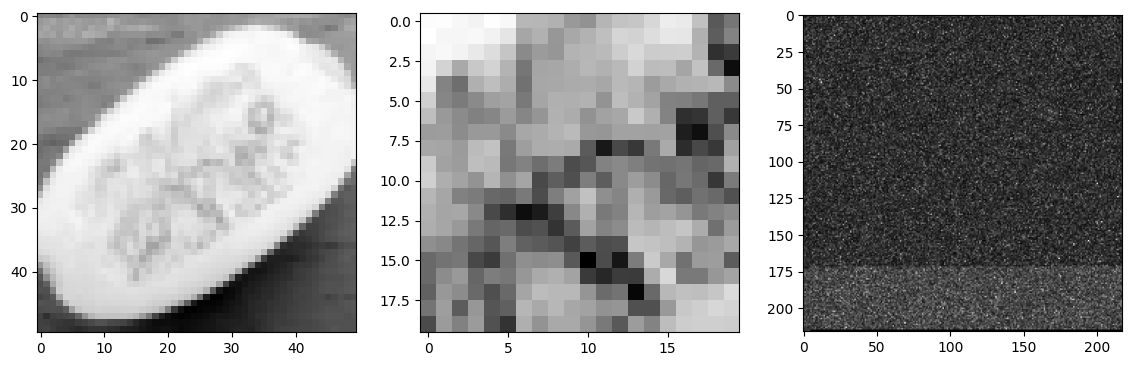

In [6]:
### show data
sample_dataset = "cat_v1"
sample_data_key = "cat_v1"
tier = "test"
sample_idx = 0

datapoint = next(iter(dls[tier][sample_dataset].dataloaders[0]))
stim, resp = datapoint.images, datapoint.responses
print(
    f"Training dataset:\t {sum(len(dl) * dl.batch_size for dl in dls['train'][sample_dataset].dataloaders)} samples"
    f"\nValidation dataset:\t {sum(len(dl) * dl.batch_size for dl in dls['val'][sample_dataset].dataloaders)} samples"
    f"\nTest dataset:\t\t {sum(len(dl) * dl.batch_size for dl in dls['test'][sample_dataset].dataloaders)} samples"

    "\n\nstimuli:"
    f"\n  {stim.shape}"
    f"\n  min={stim.min().item():.3f}  max={stim.max().item():.3f}"
    f"\n  mean={stim.mean().item():.3f}  std={stim.std().item():.3f}"
    "\nresponses:"
    f"\n  {resp.shape}"
    f"\n  min={resp.min().item():.3f}  max={resp.max().item():.3f}"
    f"\n  mean={resp.mean().item():.3f}  std={resp.std().item():.3f}"
)

### plot sample data
fig = plt.figure(figsize=(14, 6))
ax = fig.add_subplot(131)
ax.imshow(stim[sample_idx].cpu().squeeze().unsqueeze(-1), cmap="gray")

ax = fig.add_subplot(132)
ax.imshow(crop(stim[sample_idx].cpu(), config["crop_wins"][sample_data_key]).squeeze().unsqueeze(-1), cmap="gray")

ax = fig.add_subplot(133)
to_show = resp[sample_idx].cpu()
### pad with zeros
if to_show.shape[-1] % (w := np.sqrt(resp[sample_idx].cpu().shape[0]).astype(int)) != 0:
    to_show = torch.cat([to_show, torch.zeros(w - to_show.shape[-1] % w)], dim=-1)
ax.imshow(to_show.view(w, -1).squeeze(0).unsqueeze(-1), cmap="gray")

## Load other external data

In [7]:
### shapes:
# resp := responses of shape (batch, n_neurons)
# neuron_coords := neural coordinates of shape {dataset_name: {data_key: (n_neurons, 2)}}

## Set up dataloaders for training

In [8]:
class StimulusResponseDataset(torch.utils.data.Dataset):
    def __init__(self, data_key, resps, stims, neuron_coords=None):
        self.data_key = data_key
        self.samples = [
            self.tensors_to_datapoint(r, s, neuron_coords, data_key=data_key)
            for r, s in zip(resps, stims)
        ]

    def tensors_to_datapoint(self, resp, stim, neuron_coords=None, **kwargs):
        return [{
            "data_key": self.data_key,
            "resp": resp,
            "stim": stim,
            "neuron_coords": neuron_coords,
            "pupil_center": None,
            **kwargs,
        }]

    @staticmethod
    def collate_fn(batch):
        assert len(np.unique([b[0]["data_key"] for b in batch])) == 1
        return [{
            "data_key": batch[0][0]["data_key"],
            "resp": torch.stack([b[0]["resp"] for b in batch]),
            "stim": torch.stack([b[0]["stim"] for b in batch]),
            "neuron_coords": batch[0][0]["neuron_coords"],
            "pupil_center": None,
        }]

    def __getitem__(self, idx):
        return self.samples[idx]

    def __len__(self):
        return len(self.samples)


In [9]:
### set up dataloaders for training (example)
dataloaders = { # need to reinitialize after each epoch!
    "train": {
        "name_of_my_dataset": iter(torch.utils.data.DataLoader(
            StimulusResponseDataset(
                data_key="cat_v1",
                resps=resp[:8],
                stims=stim[:8],
                neuron_coords=neuron_coords["cat_v1"]["cat_v1"],
            ),
            batch_size=2,
            shuffle=True,
            collate_fn=StimulusResponseDataset.collate_fn,
        ))
    },
    "val": {
        "name_of_my_dataset": iter(torch.utils.data.DataLoader(
            StimulusResponseDataset(
                data_key="cat_v1",
                resps=resp[:8],
                stims=stim[:8],
                neuron_coords=neuron_coords["cat_v1"]["cat_v1"],
            ),
            batch_size=2,
            shuffle=False,
            collate_fn=StimulusResponseDataset.collate_fn,
        ))
    },
}

---
# Decoding models

## Generative Adversarial Network (GAN)

In [10]:
### decoder config
inp_zscored = check_if_data_zscored(cfg=config)
config["decoder"] = {
    "readin_type": (readin_type := "mei"), # "conv", "fc", "mei"
    "model": {
        "readins_config": [], # added later
        "core_cls": GAN,
        "core_config": {
            "G_kwargs": {
                "in_shape": (480,), # needs to match the # of channels of the readin output
                "layers": {
                    "conv": [
                        ("deconv", 480, 7, 2, 3),
                        ("deconv", 256, 5, 1, 2),
                        ("deconv", 256, 5, 1, 1),
                        ("deconv", 128, 4, 1, 1),
                        ("deconv", 64, 3, 1, 1),
                        ("deconv", 1, 3, 1, 0),
                    ],
                    "fc": [
                        ("deconv", 480, 7, 2, 3),
                        ("deconv", 256, 5, 1, 2),
                        ("deconv", 256, 5, 1, 1),
                        ("deconv", 128, 4, 1, 1),
                        ("deconv", 64, 3, 1, 1),
                        ("deconv", 1, 3, 1, 0),
                    ],
                    "mei": [
                        ("conv", 480, 7, 1, 3),
                        ("conv", 256, 5, 1, 2),
                        ("conv", 256, 5, 1, 2),
                        ("conv", 128, 3, 1, 1),
                        ("conv", 64, 3, 1, 1),
                        ("conv", 1, 3, 1, 1),
                    ],
                }[readin_type],
                "act_fn": nn.ReLU,
                "out_act_fn": nn.Identity,
                "dropout": 0.35,
                "batch_norm": True,
            },
            "D_kwargs": {
                "in_shape": [1, 36, 64],
                "layers": [
                    ("conv", 256, 7, 2, 2),
                    ("conv", 256, 5, 1, 2),
                    ("conv", 128, 3, 1, 1),
                    ("conv", 64, 3, 1, 1),
                    ("conv", 64, 3, 1, 1),
                    dict(), # filled later with discriminator's head
                ],
                "act_fn": nn.ReLU,
                "out_act_fn": nn.Identity, # sigmoid already in layers[-1] (head)
                "dropout": 0.3,
                "batch_norm": True,
            },
        },
    },
    "loss": {
        "loss_fn": dict(),
        "l1_reg_mul": 0,
        "l2_reg_mul": 0,
    },
    "eval_loss_name": "Alex(5) Loss",  # for "higher is better" metrics, use "<name> Loss"
    "G_opter_cls": torch.optim.AdamW,
    # "G_opter_kwargs": {"lr": 1e-4, "weight_decay": 0.08},
    "G_opter_kwargs": {"lr": 3e-5, "weight_decay": 0.3},
    "D_opter_cls": torch.optim.AdamW,
    # "D_opter_kwargs": {"lr": 1e-4, "weight_decay": 0.08},
    "D_opter_kwargs": {"lr": 3e-5, "weight_decay": 0.3},
    "G_reg": {"l1": 0, "l2": 0},
    "D_reg": {"l1": 0, "l2": 0},
    "G_adv_loss_mul": 0.1,
    "G_stim_loss_mul": 0.9,
    "D_real_loss_mul": 0.5,
    "D_fake_loss_mul": 0.5,
    "D_real_stim_labels_noise": 0.05,
    "D_fake_stim_labels_noise": 0.05,
    "n_epochs": 300,
    "load_ckpt": None,
}

### finish config for brainreader mouse
if "brainreader_mouse" in config["data"]:
    _dls, _ = get_dataloaders(config=config)
    for data_key, dset in zip(_dls["train"]["brainreader_mouse"].data_keys, _dls["train"]["brainreader_mouse"].datasets):
        ### set crop wins and losses
        config["crop_wins"][data_key] = tuple(dset[0].images.shape[-2:])
        config["decoder"]["loss"]["loss_fn"][data_key] = SSIMLoss(window=config["crop_wins"][data_key], log_loss=True, inp_normalized=True, inp_standardized=False)

        ### append discriminator's head
        config["decoder"]["model"]["core_config"]["D_kwargs"]["layers"][-1][data_key] = {
            "in_shape": [1, 36, 64],
            "layers_config": [("fc", 1)],
            "act_fn": nn.Identity,
            "out_act_fn": nn.Sigmoid,
        }

        ### append readin
        n_neurons = dset[0].responses.shape[-1]
        config["decoder"]["model"]["readins_config"].append({
            "data_key": data_key,
            "in_shape": n_neurons,
            "decoding_objective_config": None,
            "layers": {
                "conv": [
                    (ConvReadIn, {
                        "H": 18,
                        "W": 32,
                        "shift_coords": False,
                        "learn_grid": True,
                        "grid_l1_reg": 8e-3,
                        "in_channels_group_size": 1,
                        "grid_net_config": {
                            "in_channels": 1, # resp
                            "layers_config": [("fc", 8), ("fc", 64), ("fc", 18*32)],
                            "act_fn": nn.LeakyReLU,
                            "out_act_fn": nn.Identity,
                            "dropout": 0.2,
                            "batch_norm": False,
                        },
                        "pointwise_conv_config": {
                            "in_channels": n_neurons,
                            "out_channels": 480,
                            "act_fn": nn.Identity,
                            "bias": False,
                            "batch_norm": True,
                            "dropout": 0.2,
                        },
                        "gauss_blur": False,
                        "gauss_blur_kernel_size": 7,
                        "gauss_blur_sigma": "fixed", # "fixed", "single", "per_neuron"
                        "gauss_blur_sigma_init": 1.5,
                        "neuron_emb_dim": None,
                    }),
                ],
                "fc": [
                    (FCReadIn, {
                        "in_shape": n_neurons,
                        "layers_config": [
                            ("fc", 1728),
                            ("unflatten", 1, (3, 18, 32)),
                        ],
                        "act_fn": nn.LeakyReLU,
                        "out_act_fn": nn.Identity,
                        "batch_norm": True,
                        "dropout": 0.15,
                        "apply_resp_transform": False,
                    }),
                ],
                "mei": [
                    (MEIReadIn, {
                        "meis_path": os.path.join(DATA_PATH_BRAINREADER, "meis", data_key,  "meis.pt"),
                        "n_neurons": n_neurons,
                        "mei_resize_method": "resize",
                        "mei_target_shape": (36, 64),
                        "meis_trainable": False,
                        "use_neuron_coords": (_use_neuron_coords := False),
                        "neuron_emb_dim": (_neuron_emb_dim := 32),
                        "pointwise_conv_config": {
                            "out_channels": 480,
                            "bias": False,
                            "batch_norm": True,
                            "act_fn": nn.LeakyReLU,
                            "dropout": 0.2,
                        },
                        "ctx_net_config": {
                            "in_channels": 1 + 2*int(_use_neuron_coords) + (_neuron_emb_dim or 0), # resp, x, y, neuron_emb
                            "layers_config": [("fc", 128), ("fc", 36*64)],
                            "act_fn": nn.LeakyReLU,
                            "out_act_fn": nn.Identity,
                            "dropout": 0.15,
                            "batch_norm": True,
                        },
                        "l2_reg_mul": 0,
                        "apply_resp_transform": False,
                        "shift_coords": False,
                        "neuron_idxs": None, # np.random.default_rng(seed=config["seed"]).choice(n_neurons, size=int(n_neurons * 0.5), replace=False),
                        # "neuron_idxs": np.random.default_rng(seed=config["seed"]).choice(n_neurons, size=500, replace=False),
                        "device": config["device"],
                    }),
                ],
            }[config["decoder"]["readin_type"]],
        })

### finish config for cat v1
if "cat_v1" in config["data"]:
    ### set losses
    config["decoder"]["loss"]["loss_fn"]["cat_v1"] = SSIMLoss(window=config["crop_wins"]["cat_v1"], log_loss=True, inp_normalized=True, inp_standardized=False)

    ### append discriminator's head
    config["decoder"]["model"]["core_config"]["D_kwargs"]["layers"][-1]["cat_v1"] = {
        "in_shape": [1, *config["crop_wins"]["cat_v1"]],
        "layers_config": [("fc", 1)],
        "act_fn": nn.Identity,
        "out_act_fn": nn.Sigmoid,
    }

    ### append readin
    config["decoder"]["model"]["readins_config"].append({
        "data_key": "cat_v1",
        "in_shape": 46875,
        "decoding_objective_config": None,
        "layers": {
            "conv": [
                (ConvReadIn, {
                    "H": 8,
                    "W": 8,
                    "shift_coords": False,
                    "learn_grid": True,
                    "grid_l1_reg": 8e-3,
                    "in_channels_group_size": 1,
                    "grid_net_config": {
                        "in_channels": 3, # x, y, resp
                        "layers_config": [("fc", 64), ("fc", 128), ("fc", 8*8)],
                        "act_fn": nn.LeakyReLU,
                        "out_act_fn": nn.Identity,
                        "dropout": 0.15,
                        "batch_norm": False,
                    },
                    "pointwise_conv_config": {
                        "in_channels": 46875,
                        "out_channels": 480,
                        "act_fn": nn.Identity,
                        "bias": False,
                        "batch_norm": True,
                        "dropout": 0.1,
                    },
                    "gauss_blur": False,
                    "gauss_blur_kernel_size": 7,
                    "gauss_blur_sigma": "fixed", # "fixed", "single", "per_neuron"
                    "gauss_blur_sigma_init": 1.5,
                    "neuron_emb_dim": None,
                }),
            ],
            "fc": [
                (FCReadIn, {
                    "in_shape": 46875,
                    "layers_config": [
                        ("fc", 192),
                        ("unflatten", 1, (3, 8, 8)),
                    ],
                    "act_fn": nn.LeakyReLU,
                    "out_act_fn": nn.Identity,
                    "batch_norm": True,
                    "dropout": 0.15,
                    "out_channels": 8,
                }),
            ],
            "mei": [
                (MEIReadIn, {
                    "meis_path": os.path.join(DATA_PATH_CAT_V1, "meis", "cat_v1",  "meis.pt"),
                    "n_neurons": 46875,
                    "mei_resize_method": "resize",
                    "mei_target_shape": config["crop_wins"]["cat_v1"],
                    "meis_trainable": False,
                    "use_neuron_coords": (_use_neuron_coords := False),
                    "neuron_emb_dim": (_neuron_emb_dim := 16),
                    "pointwise_conv_config": {
                        "out_channels": 480,
                        "bias": False,
                        "batch_norm": True,
                        "act_fn": nn.LeakyReLU,
                        "dropout": 0.15,
                    },
                    "ctx_net_config": {
                        "in_channels": 1 + 2*int(_use_neuron_coords) + (_neuron_emb_dim or 0), # resp, x, y, neuron_emb
                        "layers_config": [("fc", 32), ("fc", 128), ("fc", np.prod(config["crop_wins"]["cat_v1"]))],
                        "act_fn": nn.LeakyReLU,
                        "out_act_fn": nn.Identity,
                        "dropout": 0.15,
                        "batch_norm": True,
                    },
                    "l2_reg_mul": 0,
                    "apply_resp_transform": False,
                    "shift_coords": False,
                    "neuron_idxs": None,
                    # "neuron_idxs": np.random.default_rng(seed=config["seed"]).choice(46875, size=500, replace=False),
                    "device": config["device"],
                }),
            ],
        }[config["decoder"]["readin_type"]],
    })

### finish config for mouse v1
if "mouse_v1" in config["data"]:
    _dls, _neuron_coords = get_dataloaders(config=config)
    for data_key, n_coords in _dls["train"]["mouse_v1"].neuron_coords.items():
        ### set crop wins and losses
        config["crop_wins"][data_key] = config["data"]["mouse_v1"]["crop_win"]
        config["decoder"]["loss"]["loss_fn"][data_key] = SSIMLoss(window=config["crop_wins"][data_key], log_loss=True, inp_normalized=True, inp_standardized=False)

        ### append discriminator's head
        config["decoder"]["model"]["core_config"]["D_kwargs"]["layers"][-1][data_key] = {
            "in_shape": [1, *config["crop_wins"][data_key]],
            "layers_config": [("fc", 1)],
            "act_fn": nn.Identity,
            "out_act_fn": nn.Sigmoid,
        }

        ### append readin
        config["decoder"]["model"]["readins_config"].append({
            "data_key": data_key,
            "in_shape": n_coords.shape[-2],
            "decoding_objective_config": None,
            "layers": {
                "conv": [
                    (ConvReadIn, {
                        "H": 10,
                        "W": 18,
                        "shift_coords": False,
                        "learn_grid": True,
                        "grid_l1_reg": 8e-3,
                        "in_channels_group_size": 1,
                        "grid_net_config": {
                            "in_channels": 3, # x, y, resp
                            "layers_config": [("fc", 32), ("fc", 86), ("fc", 18*10)],
                            "act_fn": nn.LeakyReLU,
                            "out_act_fn": nn.Identity,
                            "dropout": 0.1,
                            "batch_norm": False,
                        },
                        "pointwise_conv_config": {
                            "in_channels": n_coords.shape[-2],
                            "out_channels": 480,
                            "act_fn": nn.Identity,
                            "bias": False,
                            "batch_norm": True,
                            "dropout": 0.1,
                        },
                        "gauss_blur": False,
                        "gauss_blur_kernel_size": 7,
                        "gauss_blur_sigma": "fixed", # "fixed", "single", "per_neuron"
                        "gauss_blur_sigma_init": 1.5,
                        "neuron_emb_dim": None,
                    }),
                ],
                "fc": [
                    (FCReadIn, {
                        "in_shape": n_coords.shape[-2],
                        "layers_config": [
                            ("fc", 540),
                            ("unflatten", 1, (3, 10, 18)),
                        ],
                        "act_fn": nn.LeakyReLU,
                        "out_act_fn": nn.Identity,
                        "batch_norm": True,
                        "dropout": 0.15,
                    }),
                ],
                "mei": [
                    (MEIReadIn, {
                        "meis_path": os.path.join(DATA_PATH_MOUSE_V1, "meis", data_key,  "meis.pt"),
                        "n_neurons": n_coords.shape[-2],
                        "mei_resize_method": "resize",
                        "mei_target_shape": config["crop_wins"][data_key],
                        "meis_trainable": False,
                        "use_neuron_coords": (_use_neuron_coords := False),
                        "neuron_emb_dim": (_neuron_emb_dim := 32),
                        "pointwise_conv_config": {
                            "out_channels": 480,
                            "bias": False,
                            "batch_norm": True,
                            "act_fn": nn.LeakyReLU,
                            "dropout": 0.2,
                        },
                        "ctx_net_config": {
                            "in_channels": 1 + 2*int(_use_neuron_coords) + (_neuron_emb_dim or 0), # resp, x, y, neuron_emb
                            "layers_config": [("fc", 128), ("fc", np.prod(config["crop_wins"][data_key]))],
                            "act_fn": nn.LeakyReLU,
                            "out_act_fn": nn.Identity,
                            "dropout": 0.15,
                            "batch_norm": True,
                        },
                        "l2_reg_mul": 0,
                        "l1_reg_mul": 0,
                        "apply_resp_transform": False,
                        "shift_coords": False,
                        "neuron_idxs": None,
                        # "neuron_idxs": np.random.default_rng(seed=config["seed"]).choice(n_coords.shape[-2], size=500, replace=False),
                        "device": config["device"],
                    }),
                ],
            }[config["decoder"]["readin_type"]],
        })

In [11]:
### config for loading a model checkpoint (run this cell if you want to fine-tune/continue training a pretrained model)
config["decoder"]["load_ckpt"] = { # uncomment to load a checkpoint (and fine-tune)
    "ckpt_path": os.path.join(
        os.environ["DATA_PATH"],
        "models", "gan",
        "2025-04-25_20-19-46", "decoder_195.pt",
    ),
    "load_only_core": False, # set to True if you want to keep only the core and reset the readins
    "load_best": True, # load best model from the checkpoint (val. loss during pretraining)
    "load_opter_state": False, # don't load optimizer state for fine-tuning
    "load_history": False, # reset training history for fine-tuning
    "reset_best": True, # reset best-model tracking for fine-tuning
}

In [12]:
### utility function for merging configuration from checkpoint with the current configuration
def merge_configs_fn(cfg, ckpt_cfg):
    """ Utility function for merging configuration from checkpoint (ckpt_cfg) with the current configuration """
    ckpt_cfg["decoder"]["load_ckpt"] = cfg["decoder"]["load_ckpt"]
    ckpt_cfg = update_config_keys_to_value(ckpt_cfg, "device", cfg["device"])
    cfg = ckpt_cfg
    cfg = update_config_paths(config=cfg, new_data_path=DATA_PATH)
    return cfg, ckpt_cfg

In [13]:
### initialize the decoder model
seed_all(config["seed"])
cfg, gan, loss_fn, history, best, ckpt = init_gan_decoder(
    config=config,
    merge_configs_fn=merge_configs_fn,
)

[INFO] Loading checkpoint from /media/jan/ext_ssd/csng_data/models/gan/2025-04-25_20-19-46/decoder_195.pt...
[INFO] Loading the best model...
[INFO] Loading the full model...
[WARNING] Loading GAN state_dict without the optimizer states.


### Show example reconstructions

In [14]:
### decode
with torch.no_grad():
    stim_pred = gan(
        resp.to(config["device"]),
        data_key="cat_v1",
        neuron_coords=neuron_coords["cat_v1"]["cat_v1"]
    ) # (batch, n_channels, h, w)

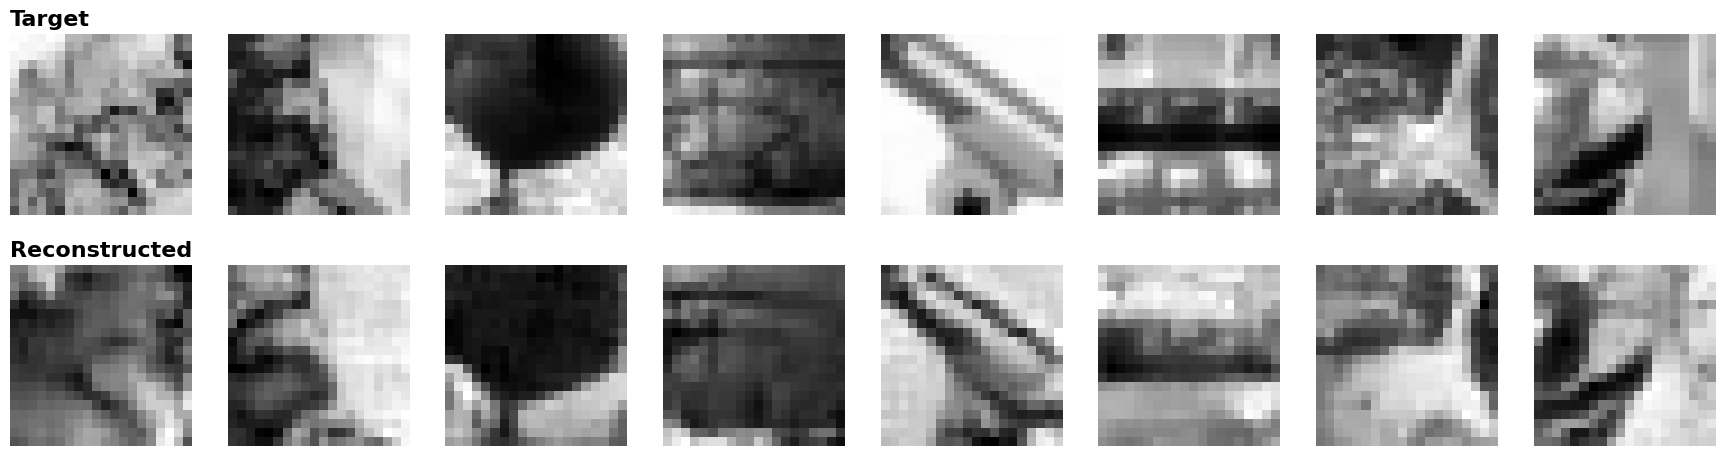

In [15]:
### show comparison
fig = plot_comparison(
    target=crop(stim[:8], config["crop_wins"]["cat_v1"]).cpu(),
    pred=crop(stim_pred[:8], config["crop_wins"]["cat_v1"]).cpu(),
    show=True,
)

### Train

In [16]:
### train (example for a single epoch)
gan.train()
single_epoch_training_history = train(
    model=gan,
    dataloaders=dataloaders["train"],
    loss_fn=loss_fn,
    config=cfg,
    history=history,
    log_freq=100,
    wdb_run=None,
    device=cfg["device"],
)

### eval
gan.eval()
val_losses = eval_decoder(
    model=gan,
    dataloaders=dataloaders["val"],
    loss_fns={"cat_v1": get_metrics(
        inp_zscored=True,
        crop_win=cfg["crop_wins"]["cat_v1"],
        device=cfg["device"]
    )},
    crop_wins=cfg["crop_wins"],
    device=cfg["device"],
)["total"]

print(dict(val_losses))

  [0/8 (0%)] G-loss: 0.187 (stim: 0.097, adv: 0.090)   D-loss: 0.417 (real: 0.416, fake: 0.000)
{'SSIM': 0.8325303196907043, 'Log SSIML': 0.08831417560577393, 'SSIML': 0.08373483270406723, 'PixCorr': 0.8302057385444641, 'PixCorr Loss': 0.1697942614555359, 'Alex(2)': 0.9107142857142857, 'Alex(2) Loss': 0.0892857142857143, 'Alex(5)': 0.9821428571428571, 'Alex(5) Loss': 0.017857142857142905, 'PL': 0.25414717197418213, 'FFL': 0.016546936705708504, 'MSE': 0.030053749680519104, 'MSE w/out min-max normalization': 0.9757900834083557, 'MAE': 0.132500559091568, 'MAE w/out min-max normalization': 0.7280848026275635, 'SSIML-PL': 0.33788201212882996}
